The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu112==1.9.1
!pip install d2l==1.0.0


# Factorization Machines

Factorization machines (FM), proposed by :citet:`Rendle.2010`, is a supervised algorithm that can be used for classification, regression, and ranking tasks. It quickly took notice and became a popular and impactful method for making predictions and recommendations. Particularly, it is a generalization of the linear regression model and the matrix factorization model. Moreover, it is reminiscent of support vector machines with a polynomial kernel. The strengths of factorization machines over the linear regression and matrix factorization are: (1) it can model $\chi$-way variable interactions, where $\chi$ is the number of polynomial order and is usually set to two. (2) A fast optimization algorithm associated with factorization machines can reduce the polynomial computation time to linear complexity, making it extremely efficient especially for high dimensional sparse inputs.  For these reasons, factorization machines are widely employed in modern advertisement and products recommendations. The technical details and implementations are described below.


## 2-Way Factorization Machines

Formally, let $x \in \mathbb{R}^d$ denote the feature vectors of one sample, and $y$ denote the corresponding label which can be real-valued label or class label such as binary class "click/non-click". The model for a factorization machine of degree two is defined as:

$$
\hat{y}(x) = \mathbf{w}_0 + \sum_{i=1}^d \mathbf{w}_i x_i + \sum_{i=1}^d\sum_{j=i+1}^d \langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j
$$

where $\mathbf{w}_0 \in \mathbb{R}$ is the global bias; $\mathbf{w} \in \mathbb{R}^d$ denotes the weights of the i-th variable; $\mathbf{V} \in \mathbb{R}^{d\times k}$ represents the feature embeddings; $\mathbf{v}_i$ represents the $i^\textrm{th}$ row of $\mathbf{V}$; $k$ is the dimensionality of latent factors; $\langle\cdot, \cdot \rangle$ is the dot product of two vectors.  $\langle \mathbf{v}_i, \mathbf{v}_j \rangle$ model the interaction between the $i^\textrm{th}$ and $j^\textrm{th}$ feature. Some feature interactions can be easily understood so they can be designed by experts. However, most other feature interactions are hidden in data and difficult to identify. So modeling feature interactions automatically can greatly reduce the efforts in feature engineering. It is obvious that the first two terms correspond to the linear regression model and the last term is an extension of the matrix factorization model. If the feature $i$ represents an item and the feature $j$ represents a user, the third term is exactly the dot product between user and item embeddings. It is worth noting that FM can also generalize to higher orders (degree > 2). Nevertheless, the numerical stability might weaken the generalization.


## An Efficient Optimization Criterion

Optimizing the factorization machines in a  straight forward method leads to a complexity of $\mathcal{O}(kd^2)$ as all pairwise interactions require to be computed. To solve this inefficiency problem, we can reorganize the third term of FM which could greatly reduce the computation cost, leading to a linear time complexity ($\mathcal{O}(kd)$).  The reformulation of the pairwise interaction term is as follows:

$$
\begin{aligned}
&\sum_{i=1}^d \sum_{j=i+1}^d \langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j \\
 &= \frac{1}{2} \sum_{i=1}^d \sum_{j=1}^d\langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j - \frac{1}{2}\sum_{i=1}^d \langle\mathbf{v}_i, \mathbf{v}_i\rangle x_i x_i \\
 &= \frac{1}{2} \big (\sum_{i=1}^d \sum_{j=1}^d \sum_{l=1}^k\mathbf{v}_{i, l} \mathbf{v}_{j, l} x_i x_j - \sum_{i=1}^d \sum_{l=1}^k \mathbf{v}_{i, l} \mathbf{v}_{i, l} x_i x_i \big)\\
 &=  \frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i) (\sum_{j=1}^d \mathbf{v}_{j, l}x_j) - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2 \big ) \\
 &= \frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i)^2 - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2)
 \end{aligned}
$$

With this reformulation, the model complexity are decreased greatly. Moreover, for sparse features, only non-zero elements needs to be computed so that the overall complexity is linear to the number of non-zero features.

To learn the FM model, we can use the MSE loss for regression task, the cross-entropy loss for classification tasks, and the BPR loss for ranking task. Standard optimizers such as stochastic gradient descent and Adam are viable for optimization.


In [1]:
import os
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Model Implementation
The following code implement the factorization machines. It is clear to see that FM consists a linear regression block and an efficient feature interaction block. We apply a sigmoid function over the final score since we treat the CTR prediction as a classification task.


In [2]:
class FM(nn.Block):
    def __init__(self, field_dims, num_factors):
        super(FM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Dense(1, use_bias=True)

    def forward(self, x):
        square_of_sum = np.sum(self.embedding(x), axis=1) ** 2
        sum_of_square = np.sum(self.embedding(x) ** 2, axis=1)
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True)
        x = npx.sigmoid(x)
        return x

## Load the Advertising Dataset
We use the CTR data wrapper from the last section to load the online advertising dataset.


In [3]:
batch_size = 2048
data_dir = d2l.download_extract('ctr')
train_data = d2l.CTRDataset(os.path.join(data_dir, 'train.csv'))
test_data = d2l.CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
train_iter = gluon.data.DataLoader(
    train_data, shuffle=True, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(
    test_data, shuffle=False, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())

[07:05:14] ../src/storage/storage.cc:196: Using Pooled (Naive) StorageManager for CPU


## Train the Model
Afterwards, we train the model. The learning rate is set to 0.02 and the embedding size is set to 20 by default. The `Adam` optimizer and the `SigmoidBinaryCrossEntropyLoss` loss are used for model training.


loss 0.506, train acc 0.273, test acc 0.273
45373.6 examples/sec on [gpu(0), gpu(1)]


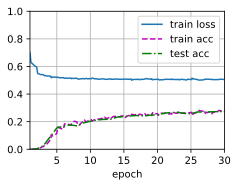

In [4]:
devices = d2l.try_all_gpus()
net = FM(train_data.field_dims, num_factors=20)
net.initialize(init.Xavier(), ctx=devices)
lr, num_epochs, optimizer = 0.02, 30, 'adam'
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {'learning_rate': lr})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## Summary

* FM is a general framework that can be applied on a variety of tasks such as regression, classification, and ranking.
* Feature interaction/crossing is important for prediction tasks and the 2-way interaction can be efficiently modeled with FM.

## Exercises

* Can you test FM on other dataset such as Avazu, MovieLens, and Criteo datasets?
* Vary the embedding size to check its impact on performance, can you observe a similar pattern as that of matrix factorization?


[Discussions](https://discuss.d2l.ai/t/406)
